In [18]:
import sys
sys.path.append("/home/federico/programming/CM/")
# sys.path.append("/home/federico/Desktop/University/CM/")


# TODO: controllare salvataggio immagini, rimuovere prima di consegnare

In [16]:
from src.LS.LS import LS
from src.LS.testLS import scaling, generic_test, generate
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import random
import sys
import time
import matplotlib.pyplot as plt

from src.utils import *
from src.NN.metrics import mean_squared_error

from datetime import datetime as dt
import time

In [3]:
random.seed(42) # Needed for reproducibilityscaling

In [4]:
def plot_stats(time_qr_np, time_qr_a3, time_ls_np, time_ls_a3, mrange, n, save=True):
    
    m = mrange.stop
    
    # --- Plotting QR stats ---
    plt.plot(mrange, time_qr_np, "^-", label="np")
    plt.xlabel ("m")
    plt.ylabel ("time (msec)")
    plt.title (f"QR factorizzation of a matrix {mrange}x{n} (NP)")
    plt.gca().set_xlim ((min(mrange)-1, max(mrange)+1))

    if save: plt.savefig(f"report_tests/LS/Scaling/QRscaling_np_n{n}m{m}.png")
    else: plt.show()
    plt.clf()

    plt.plot (mrange, time_qr_a3, "o-", label="mio")
    plt.xlabel ("m")
    plt.ylabel ("time (msec)")
    plt.title (f"QR factorizzation of a matrix {m}x{n} (A3)")
    plt.gca().set_xlim ((min(mrange)-1, max(mrange)+1))

    if save: plt.savefig(f"report_tests/LS/Scaling/QRscaling_a3_n{n}m{m}.png")
    else: plt.show()
    plt.clf()
    
    plt.plot(mrange, time_qr_np, "^-", label="np")
    plt.plot (mrange, time_qr_a3, "o-", label="(A3)")
    plt.legend()
    plt.xlabel ("m")
    plt.ylabel ("time (msec)")
    plt.title (f"QR factorizzation of a matrix {m}x{n}")
    plt.gca().set_xlim ((min(mrange)-1, max(mrange)+1))

    if save: plt.savefig(f"report_tests/LS/Scaling/QRscaling_comparison_n{n}m{m}.png")
    else: plt.show()
    plt.clf()
    
    
    # --- Plotting LS stats ---
    plt.plot(mrange, time_ls_np, "^-")
    plt.xlabel ("m")
    plt.ylabel ("time (msec)")
    plt.title (f"LS of a matrix {m}x{n} (NP)")
    plt.gca().set_xlim ((min(mrange)-1, max(mrange)+1))

    if save: plt.savefig(f"report_tests/LS/Scaling/LSscaling_np_n{n}m{m}.png")
    else: plt.show()
    plt.clf()

    plt.plot (mrange, time_ls_a3, "o-")
    plt.xlabel ("m")
    plt.ylabel ("time (msec)")
    plt.title (f"LS of a matrix {m}x{n} (A3)")
    plt.gca().set_xlim ((min(mrange)-1, max(mrange)+1))

    if save: plt.savefig(f"report_tests/LS/Scaling/LSscaling_a3_n{n}m{m}.png")
    else: plt.show()
    plt.clf()
    
    plt.plot(mrange, time_qr_np, "^-", label="np")
    plt.plot (mrange, time_qr_a3, "o-", label="(A3)")
    plt.legend()
    plt.xlabel ("m")
    plt.ylabel ("time (msec)")
    plt.title (f"LS of a matrix {m}x{n}")
    plt.gca().set_xlim ((min(mrange)-1, max(mrange)+1))

    if save: plt.savefig(f"report_tests/LS/Scaling/LSscaling_comparison_n{n}m{m}.png")
    else: plt.show()
    plt.clf()

# Scaling test

In [7]:
starting_m = 1000
last_m = 11000
n = 100
step = 1000
repeat = 20
time_qr_np, time_qr_a3, time_ls_np, time_ls_a3 = scaling(starting_m, last_m, n, step, repeat)

n=100, m=11000, t=20
m        QR A3      delta      QR np      delta      LS A3      delta      LS np      delta     
----------------------------------------------------------------------------------------------------
1000   || 202.2400 | 202.2400 |   5.0203 |   5.0203 |  40.5648 |  40.5648 |   6.9295 |   6.9295
2000   || 323.0937 | 120.8536 |  10.8142 |   5.7939 |  79.8693 |  39.3045 |  10.8600 |   3.9306
3000   || 446.2046 | 123.1110 |  15.3591 |   4.5450 | 112.5876 |  32.7182 |  14.7223 |   3.8623
4000   || 522.0027 |  75.7981 |  19.6636 |   4.3045 | 141.6217 |  29.0341 |  17.9011 |   3.1788
5000   || 761.6052 | 239.6025 |  28.7338 |   9.0702 | 215.3100 |  73.6882 |  24.9919 |   7.0908
6000   || 767.3071 |   5.7019 |  29.4270 |   0.6932 | 228.4099 |  13.1000 |  25.0433 |   0.0514
7000   || 922.9616 | 155.6546 |  37.8914 |   8.4643 | 287.9382 |  59.5282 |  31.8884 |   6.8451
8000   || 1060.6008 | 137.6391 |  42.6229 |   4.7316 | 321.7908 |  33.8526 |  34.1196 |   2.2312
9000   || 11

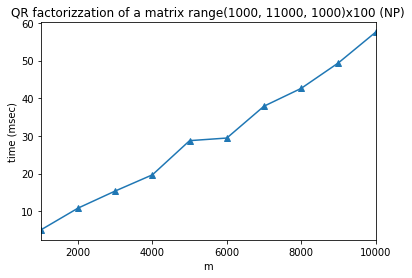

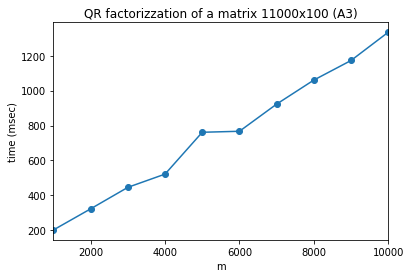

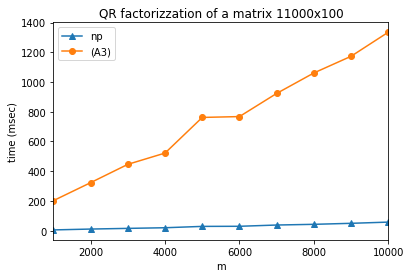

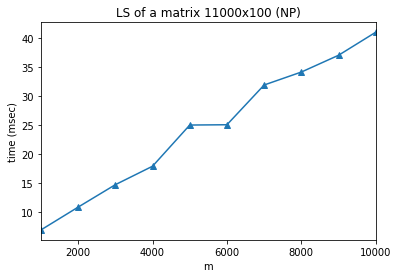

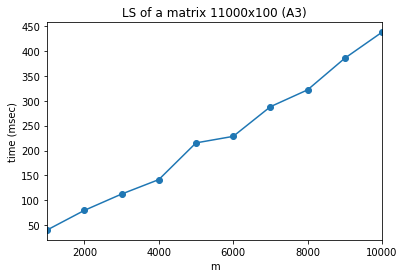

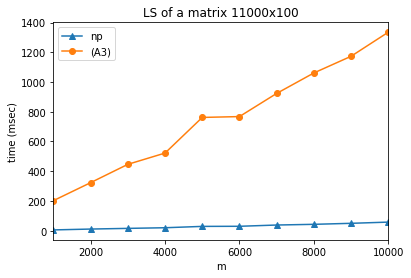

<Figure size 432x288 with 0 Axes>

In [8]:
plot_stats(time_qr_np, time_qr_a3, time_ls_np, time_ls_a3, range(starting_m, last_m, step), n, save=False)

In [11]:
starting_m = 10000
last_m = 60000
n = 100
step = 10000
repeat = 5
time_qr_np, time_qr_a3, time_ls_np, time_ls_a3 = scaling(starting_m, last_m, n, step, repeat)

n=100, m=60000, t=5
m        QR A3      delta      QR np      delta      LS A3      delta      LS np      delta     
----------------------------------------------------------------------------------------------------
10000  || 1158.2692 | 1158.2692 |  57.3444 |  57.3444 | 407.5132 | 407.5132 |  43.2382 |  43.2382
20000  || 2577.8430 | 1419.5738 | 138.9310 |  81.5866 | 886.8210 | 479.3078 |  80.9192 |  37.6810
30000  || 3861.0168 | 1283.1738 | 193.6398 |  54.7088 | 1319.5834 | 432.7624 | 131.8032 |  50.8840
40000  || 5173.2870 | 1312.2702 | 428.0986 | 234.4588 | 1918.5974 | 599.0140 | 244.6606 | 112.8574
50000  || 6637.5838 | 1464.2968 | 690.0062 | 261.9076 | 2410.9934 | 492.3960 | 341.1962 |  96.5356

m        residual A3              residual np              reconstruct a3           reconstruct np          
----------------------------------------------------------------------------------------------------
10000  ||     0.9948450324451379 |     0.9948450326919556 | 1.1574647189543183

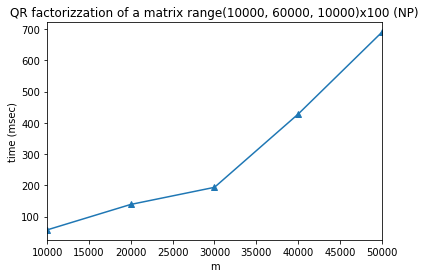

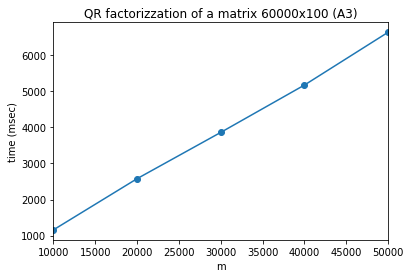

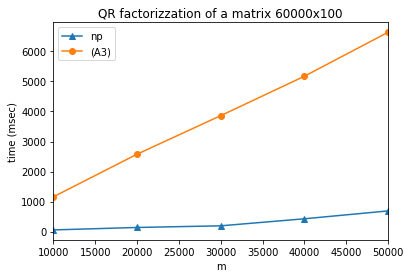

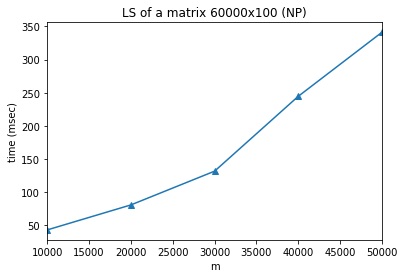

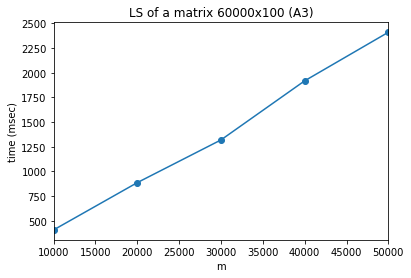

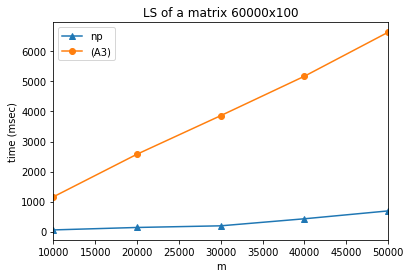

<Figure size 432x288 with 0 Axes>

In [12]:
plot_stats(time_qr_np, time_qr_a3, time_ls_np, time_ls_a3, range(starting_m, last_m, step), n, save=False)

# CUP test

In [13]:
cup = '../../data/ML-CUP20-TR.csv'

In [17]:
M, M_test, b, b_test = load_CUP(cup, split=0)
res, resnp = generic_test(M, b, 'CUP')
print(f"MSE A3: {mean_squared_error(np.matmul(M, res),b)}")
print(f"MSE np: {mean_squared_error(np.matmul(M, resnp),b)}\n\n")


A,b = generate(5000,50)
res, resnp = generic_test(A, b, 'RANDOM')
print(f"MSE A3: {mean_squared_error(np.matmul(A, res),b)}")
print(f"MSE np: {mean_squared_error(np.matmul(A, resnp),b)}")

---------- CUP DATASET ----------
Solved (m x n): (1524,10) in 3.656 msec, w/ np in 0.582 msec - Reverting and reconstruction: 9.409 msec, w/ np took: 0.677 msec
res error: 1.0537730959643323 - np_res error: 0.9962999753126451
QR error: 4.933387024233579e-16 - QR error w/ np: 3.2893174070752366e-16

MSE A3: 972.4632084924591
MSE np: 869.279035729481


---------- RANDOM DATASET ----------
Solved (m x n): (5000,50) in 55.756 msec, w/ np in 7.652 msec - Reverting and reconstruction: 207.391 msec, w/ np took: 8.73 msec
res error: 0.9959171302461305 - np_res error: 0.9959171414375305
QR error: 8.54042875422175e-16 - QR error w/ np: 4.638206618778895e-08

MSE A3: 0.5064146902975466
MSE np: 0.5064146518707275
